In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkFiles

spark = SparkSession.builder.appName('EDA').getOrCreate()
spark.sparkContext.addFile('https://cnecovid.isciii.es/covid19/resources/datos_ccaas.csv')

In [2]:
df = spark.read.csv(SparkFiles.get('datos_ccaas.csv'), inferSchema=True, header=True)

In [3]:
df.describe().toPandas()

summary ccaa_iso       fecha          num_casos num_casos_prueba_pcr  \
0   count     6270        6270               6270                 6270   
1    mean     None        None  256.0031897926635   232.14003189792663   
2  stddev     None        None  589.7976747719568     532.270801024463   
3     min       AN  2020-01-01                  0                    0   
4     max       VC  2020-11-25               6731                 6717   

  num_casos_prueba_test_ac num_casos_prueba_otras num_casos_prueba_desconocida  
0                     6270                   6270                         6270  
1        0.740829346092504      22.79122807017544           0.3311004784688995  
2       4.8733169409799295     120.11687674928866            2.636318102720163  
3                        0                      0                            0  
4                       96                   1863                           68

In [4]:
df.printSchema()

root
 |-- ccaa_iso: string (nullable = true)
 |-- fecha: string (nullable = true)
 |-- num_casos: integer (nullable = true)
 |-- num_casos_prueba_pcr: integer (nullable = true)
 |-- num_casos_prueba_test_ac: integer (nullable = true)
 |-- num_casos_prueba_otras: integer (nullable = true)
 |-- num_casos_prueba_desconocida: integer (nullable = true)



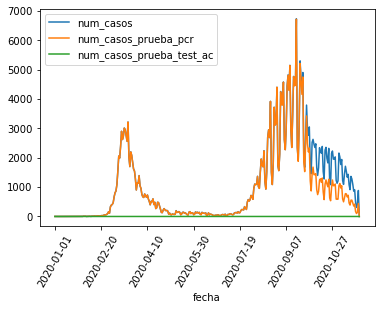

In [5]:
df.filter("ccaa_iso ='MD'").toPandas()\
    .plot(x='fecha', y=['num_casos', 'num_casos_prueba_pcr', 'num_casos_prueba_test_ac'], rot=60)

In [6]:
from pyspark.sql.functions import col
data = df.filter(col('ccaa_iso').isin(['MD', 'CM', 'CT', 'CL', 'AN'])).sample(fraction=0.9).toPandas()

/Users/josem/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/Users/josem/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/Users/josem/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/Users/josem/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/Users/josem/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/Users/josem/anaconda3/lib/python3.7/site-packages

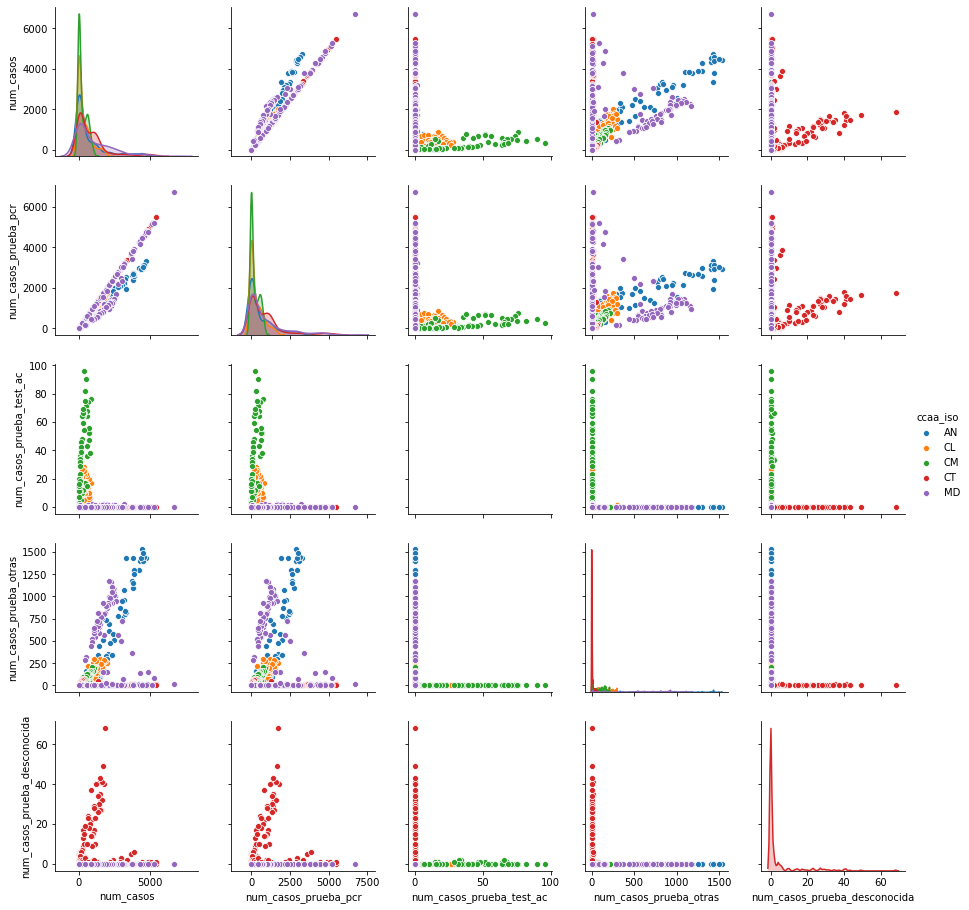

In [7]:
import seaborn as sns
sns.pairplot(data=data, hue='ccaa_iso')

In [8]:
df.corr('num_casos', 'num_casos_prueba_pcr')

0.9823074660583597

In [9]:
df.corr('num_casos', 'num_casos_prueba_test_ac')

0.01237097491458167

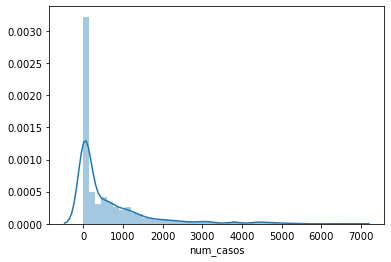

In [10]:
sns.distplot(data.num_casos)

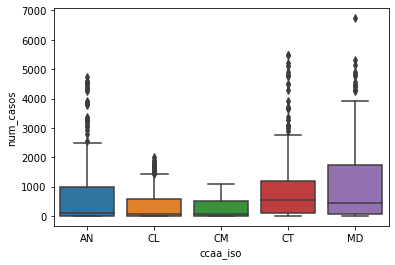

In [11]:
sns.boxplot(x=data.ccaa_iso, y=data.num_casos)

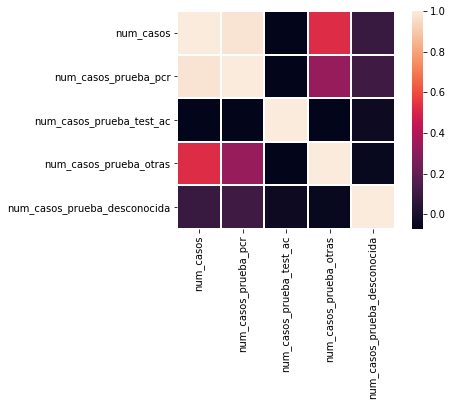

In [12]:
sns.heatmap(data.corr(), linewidths=1, square=True)

In [14]:
data = df.filter(col('ccaa_iso').isin(['MD', 'CM', 'CT', 'CL', 'AN'])).sample(fraction=0.9)
data.columns

['ccaa_iso',
 'fecha',
 'num_casos',
 'num_casos_prueba_pcr',
 'num_casos_prueba_test_ac',
 'num_casos_prueba_otras',
 'num_casos_prueba_desconocida']

In [15]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(
    inputCols=['num_casos_prueba_pcr', 'num_casos_prueba_test_ac', 
               'num_casos_prueba_otras', 'num_casos_prueba_desconocida'],
    outputCol='all_features')
final_data = assembler.transform(data)

In [16]:
from pyspark.ml.feature import PCA
pca = PCA(k=2, inputCol='all_features', outputCol='features')
pcaModel = pca.fit(final_data)

output = pcaModel.transform(final_data)

In [17]:
output.toPandas()

ccaa_iso       fecha  num_casos  num_casos_prueba_pcr  \
0          AN  2020-01-01          0                     0   
1          CL  2020-01-01          0                     0   
2          CM  2020-01-01          0                     0   
3          CT  2020-01-01          0                     0   
4          MD  2020-01-01          1                     1   
...       ...         ...        ...                   ...   
1501       AN  2020-11-25          1                     1   
1502       CL  2020-11-25          0                     0   
1503       CM  2020-11-25          0                     0   
1504       CT  2020-11-25          0                     0   
1505       MD  2020-11-25          0                     0   

      num_casos_prueba_test_ac  num_casos_prueba_otras  \
0                            0                       0   
1                            0                       0   
2                            0                       0   
3                            0                       0   
4                            0                       0   
...                        ...                     ...   
1501                         0                       0   
1502                         0                       0   
1503                         0                       0   
1504                         0                       0   
1505                         0                       0   

      num_casos_prueba_desconocida          all_features  \
0                                0  (0.0, 0.0, 0.0, 0.0)   
1                                0  (0.0, 0.0, 0.0, 0.0)   
2                                0  (0.0, 0.0, 0.0, 0.0)   
3                                0  (0.0, 0.0, 0.0, 0.0)   
4                                0  (1.0, 0.0, 0.0, 0.0)   
...                            ...                   ...   
1501                             0  (1.0, 0.0, 0.0, 0.0)   
1502                             0  (0.0, 0.0, 0.0, 0.0)   
1503                             0  (0.0, 0.0, 0.0, 0.0)   
1504                             0  (0.0, 0.0, 0.0, 0.0)   
1505                             0  (0.0, 0.0, 0.0, 0.0)   

                                         features  
0                                      [0.0, 0.0]  
1                                      [0.0, 0.0]  
2                                      [0.0, 0.0]  
3                                      [0.0, 0.0]  
4     [-0.9957935792732608, -0.09161925460318263]  
...                                           ...  
1501  [-0.9957935792732608, -0.09161925460318263]  
1502                                   [0.0, 0.0]  
1503                                   [0.0, 0.0]  
1504                                   [0.0, 0.0]  
1505                                   [0.0, 0.0]  

[1506 rows x 9 columns]

In [18]:
pcaModel.explainedVariance

DenseVector([0.9456, 0.0543])

In [19]:
pcaModel.pc.toArray()

array([[-9.95793579e-01, -9.16192546e-02],
       [ 7.88743637e-04, -1.96498517e-03],
       [-9.16194567e-02,  9.95789723e-01],
       [-6.32867160e-04, -2.20867029e-03]])